**Stock prices follows Brownian motion, making it very difficult to predict. I personally do not belive in technical trading. I am just explroing some the deep learning techniques to predict the stock price.**

In [ ]:
import keras
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 Installing quandl

 
 We will take data of HDFC bank from BSE.

In [4]:
!!pip install quandl

['Collecting quandl',
 '  Downloading Quandl-3.6.1-py2.py3-none-any.whl (26 kB)',
 'Requirement already satisfied: more-itertools in /usr/local/lib/python3.7/dist-packages (from quandl) (8.8.0)',
 'Requirement already satisfied: numpy>=1.8 in /usr/local/lib/python3.7/dist-packages (from quandl) (1.19.5)',
 'Requirement already satisfied: python-dateutil in /usr/local/lib/python3.7/dist-packages (from quandl) (2.8.1)',
 'Requirement already satisfied: six in /usr/local/lib/python3.7/dist-packages (from quandl) (1.15.0)',
 'Collecting inflection>=0.3.1',
 '  Downloading inflection-0.5.1-py2.py3-none-any.whl (9.5 kB)',
 'Requirement already satisfied: pandas>=0.14 in /usr/local/lib/python3.7/dist-packages (from quandl) (1.1.5)',
 'Requirement already satisfied: requests>=2.7.0 in /usr/local/lib/python3.7/dist-packages (from quandl) (2.23.0)',
 'Requirement already satisfied: pytz>=2017.2 in /usr/local/lib/python3.7/dist-packages (from pandas>=0.14->quandl) (2018.9)',
 'Requirement already

In [9]:
my_data =  quandl.get('BSE/BOM500570', start_date='2000-03-13', end_date='2021-08-09')
my_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2000-03-13,136.75,136.75,119.15,120.90,125.539901,790942.0,2845.0,99294780.0,NaN,NaN,17.60,-15.85
2000-03-14,123.00,130.55,120.10,130.55,127.875925,727722.0,2322.0,93058124.0,NaN,NaN,10.45,7.55
2000-03-15,133.90,139.50,130.00,133.40,135.698842,699924.0,2947.0,94978876.0,NaN,NaN,9.50,-0.50
2000-03-16,144.00,144.00,144.00,144.00,144.000000,2300.0,1.0,331200.0,NaN,NaN,0.00,0.00
2000-03-21,147.80,153.50,143.20,149.80,148.103816,912761.0,3717.0,135183387.0,NaN,NaN,10.30,2.00


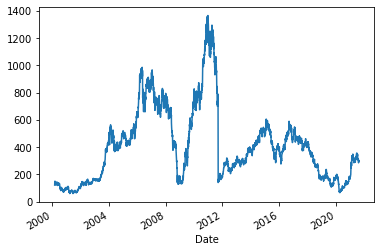

In [23]:
my_data['Close'].plot()

In [11]:
from sklearn.preprocessing import MinMaxScaler

We make the last 10 days of data as the input data and data of 11th day as output data.

Here, We are just trying to predict the one day data.

Which is not very useful though.

In [12]:
cl = my_data.Close.astype('float32')
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)

my_data['Close_scaled']=cl

def processData(data,lb):
    new_data = pd.DataFrame(index = my_data.index, data=np.array([data.Close_scaled.shift(-1*i).values for i in range(lb)]).T)
    Y=my_data['Close'].iloc[lb:].values
    X=new_data.values
    return np.array(X[:len(data)-lb-1]),np.array(Y[:len(data)-lb-1])

lb=10
X,y = processData(my_data,lb)

X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

4782 10
532 10
4782
532


In [15]:
from keras.layers import LSTM
from keras import Sequential
from keras.layers import Dense

We train LSTM(Long Short Term Memory) model with the data.

In [16]:
model = Sequential()

model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
model.summary()

Epoch 1/300
150/150 [==============================] - 25s 43ms/step - loss: 176684.7202 - val_loss: 22929.6445
Epoch 2/300
150/150 [==============================] - 5s 36ms/step - loss: 156792.3435 - val_loss: 16347.5098
Epoch 3/300
150/150 [==============================] - 6s 37ms/step - loss: 141522.8986 - val_loss: 11736.7578
Epoch 4/300
150/150 [==============================] - 6s 37ms/step - loss: 128608.1842 - val_loss: 8789.8760
Epoch 5/300
150/150 [==============================] - 5s 37ms/step - loss: 117705.8908 - val_loss: 7297.3335
Epoch 6/300
150/150 [==============================] - 5s 36ms/step - loss: 108697.0302 - val_loss: 7033.5415
Epoch 7/300
150/150 [==============================] - 5s 37ms/step - loss: 101338.5029 - val_loss: 7787.7109
Epoch 8/300
150/150 [==============================] - 6s 37ms/step - loss: 95410.8427 - val_loss: 9370.8252
Epoch 9/300
150/150 [==============================] - 6s 38ms/step - loss: 90718.2884 - val_loss: 11612.2832
Epoch 1

Text(0.5, 1.0, 'Train Dataset')

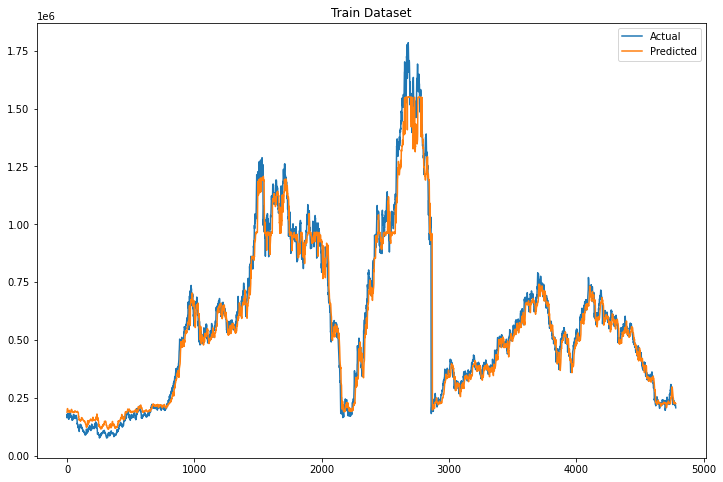

In [17]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

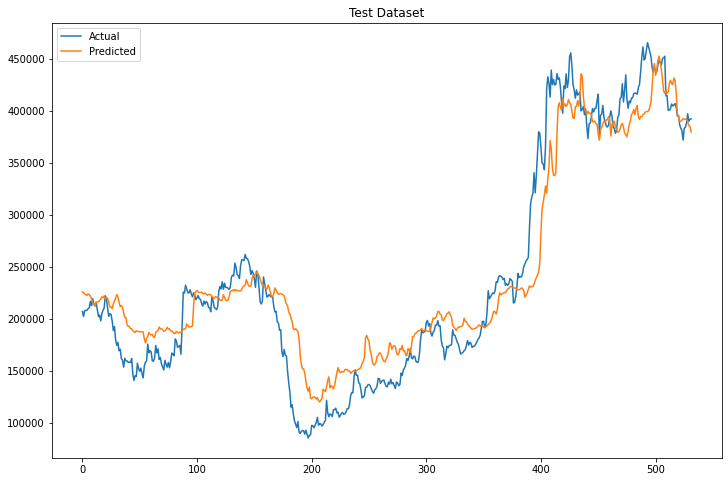

In [18]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")